-----------


# Classificação Usando GNN

### Preparando Dados

In [2]:
import parkinson

import torch
from torch import nn
from torch_geometric.data import Data

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

In [3]:
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')
prodomal_data = parkinson.utils.data.batch_read('../data/Prodomals_columns')

100%|██████████| 188/188 [00:04<00:00, 43.34it/s]


In [4]:
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

parkinson_correlation_matrix = [ts.corr(method='pearson').to_numpy() for ts in control_atlas_data]
control_correlation_matrix = [ts.corr(method='pearson').to_numpy() for ts in parkinson_atlas_data]
prodomal_correlation_matrix = [ts.corr(method='pearson').to_numpy() for ts in prodomal_atlas_data]

X = np.concatenate([parkinson_correlation_matrix, prodomal_correlation_matrix, control_correlation_matrix], axis=0)
y = np.concatenate([
    [2 for _ in range(len(parkinson_data))],
    [1 for _ in range(len(prodomal_data))],
    [0 for _ in range(len(control_data))]
], axis=0)

X, y = parkinson.utils.data.filter_data(X, y)

Matrix de correlação completa

<Axes: >

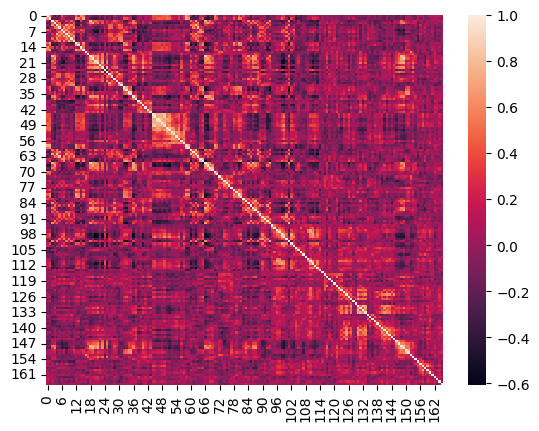

In [5]:
# Paciente 0
sns.heatmap(parkinson_correlation_matrix[0])

Segundo o artigo "Systematic evaluation of fMRI data-processing pipelines for consistent functional connectomics"

https://www.nature.com/articles/s41467-024-48781-5#ref-CR98

Um pipeline consistente para a geração de grafos é: Pearson correlation, weighted edges, and the OMST method of optimising the balance between network efficiency and wiring cost. 

Implementação do OMST (Orthogonal Minimal Spanning Tree)

Starting build. Initial GE=1.0000, Initial Cost=1958.47
------------------------------
Iteration 1: GCE = 0.0766
Iteration 2: GCE = 0.1828
Iteration 3: GCE = 0.2178
Iteration 4: GCE = 0.2328
Iteration 5: GCE = 0.2415
Iteration 6: GCE = 0.2417
Iteration 7: GCE = 0.2411
GCE decreased. Halting at 6 OMST(s).
------------------------------

--- Results ---
Optimal number of OMSTs: 6
Final Graph Edges: 990
Maximum GCE achieved: 0.2417


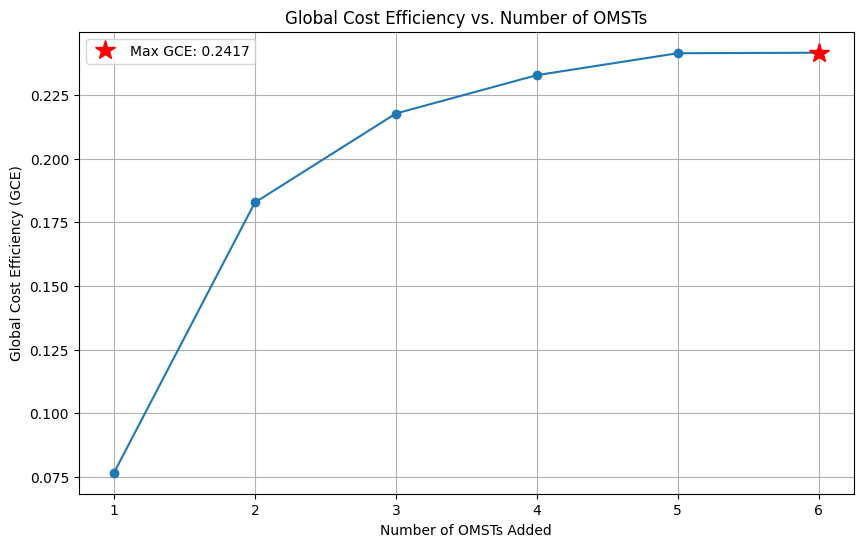

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Tuple

class OMSTBuilder:
    """ Orthogonal Minimal Spanning Tree (OMST) Builder
    This class iteratively finds Orthogonal Minimal Spanning Trees (OMSTs)
    and adds them to a cumulative graph, stopping when the Global Cost
    Efficiency (GCE) no longer increases.
    """

    def __init__(self, adj_matrix: np.ndarray):

        if not isinstance(adj_matrix, np.ndarray) or adj_matrix.ndim != 2 or adj_matrix.shape[0] != adj_matrix.shape[1]:
            raise ValueError("Input must be a square 2D NumPy array.")

        # Corresponds to the input 'CIJ' in the MATLAB script.
        # We use abs() to ensure all weights are positive, as is typical for correlation matrices.
        self.adj_matrix = np.abs(adj_matrix)
        self.n_nodes = self.adj_matrix.shape[0]

        # --- Initialize metrics of the original graph ---
        # Corresponds to 'cost_ini'
        self._initial_cost = np.sum(np.triu(self.adj_matrix))
        # Corresponds to 'E_ini'
        self._initial_ge = self._calculate_global_efficiency_from_matrix(self.adj_matrix)

        # --- Initialize graphs for the build process ---
        # Corresponds to 'CIJnotintree' - the graph of remaining edges.
        # We work with NetworkX graphs for efficiency.
        self._residual_graph = self._create_distance_graph(self.adj_matrix)

        # --- Public attributes to store the results ---
        self.omsts: List[nx.Graph] = []
        self.gce_scores: List[float] = []
        self.final_graph: nx.Graph = nx.Graph()

    def _create_distance_graph(self, matrix: np.ndarray) -> nx.Graph:
        """
        Helper to create a distance-weighted graph from a similarity matrix.
        In distance graphs, lower weight is better.
        This corresponds to `1./CIJ` in the MATLAB script.
        """
        with np.errstate(divide='ignore', invalid='ignore'):
            distance_matrix = 1 / matrix
        # Set non-finite values (from 1/0 or NaNs) to 0, indicating no path.
        distance_matrix[~np.isfinite(distance_matrix)] = 0
        return nx.from_numpy_array(distance_matrix)

    def _calculate_global_efficiency_from_matrix(self, matrix: np.ndarray) -> float:
        """Calculates the global efficiency directly from a similarity matrix."""
        dist_graph = self._create_distance_graph(matrix)
        return nx.global_efficiency(dist_graph)

    def _calculate_gce(self, graph: nx.Graph) -> float:
        """
        Calculates the Global Cost Efficiency for the current cumulative graph.
        This corresponds to the formula `E/E_ini - cost(counter)`.
        """
        if self._initial_cost == 0 or self._initial_ge == 0:
            return -np.inf

        # Cost is the sum of weights (similarity) as a fraction of the initial total cost.
        current_cost = graph.size(weight='weight') / self._initial_cost

        # Efficiency is calculated on the corresponding distance graph.
        current_ge = self._calculate_global_efficiency_from_matrix(nx.to_numpy_array(graph))
        
        return (current_ge / self._initial_ge) - current_cost

    def build(self, verbose: bool = True) -> 'OMSTBuilder':
        """
        Executes the iterative build process, corresponding to the main
        `while delta > 0` loop in the MATLAB script.

        Args:
            verbose: If True, prints the GCE score at each iteration.

        Returns:
            The instance itself, allowing for method chaining (e.g., builder.build().plot()).
        """
        # This graph will accumulate the edges from the found OMSTs.
        cumulative_graph = nx.Graph()
        previous_gce = -np.inf

        if verbose:
            print(f"Starting build. Initial GE={self._initial_ge:.4f}, Initial Cost={self._initial_cost:.2f}")
            print("-" * 30)

        for i in range(self.n_nodes * (self.n_nodes - 1) // 2): # Max possible iterations
            if self._residual_graph.number_of_edges() == 0:
                if verbose: print("\nNo more edges available. Stopping.")
                break

            # Find the next MST from the remaining edges.
            mst = nx.minimum_spanning_tree(self._residual_graph, weight='weight')
            if mst.number_of_edges() == 0:
                if verbose: print("\nGraph disconnected. Stopping.")
                break
            
            candidate_graph = cumulative_graph.copy()
            for u, v in mst.edges():
                weight = self.adj_matrix[u, v]
                candidate_graph.add_edge(u, v, weight=weight)

            # Calculate the GCE of this new candidate graph.
            current_gce = self._calculate_gce(candidate_graph)

            if verbose:
                print(f"Iteration {i+1}: GCE = {current_gce:.4f}")

            # The stopping condition: if GCE does not improve, we've found our optimal graph.
            if current_gce < previous_gce:
                if verbose:
                    print(f"GCE decreased. Halting at {len(self.omsts)} OMST(s).")
                    print("-" * 30)
                break

            previous_gce = current_gce
            self.gce_scores.append(current_gce)
            self.omsts.append(mst)
            cumulative_graph = candidate_graph
 
            self._residual_graph.remove_edges_from(mst.edges())
        
        self.final_graph = cumulative_graph
        return self

    def plot_gce_curve(self):
        """Plots the GCE score against the number of OMSTs added."""
        if not self.gce_scores:
            print("No scores to plot. Run .build() first.")
            return

        plt.figure(figsize=(10, 6))
        iterations = range(1, len(self.gce_scores) + 1)
        plt.plot(iterations, self.gce_scores, marker='o', linestyle='-')
        
        max_gce = max(self.gce_scores)
        max_idx = self.gce_scores.index(max_gce)
        plt.plot(max_idx + 1, max_gce, 'r*', markersize=15, label=f'Max GCE: {max_gce:.4f}')
        
        plt.title("Global Cost Efficiency vs. Number of OMSTs")
        plt.xlabel("Number of OMSTs Added")
        plt.ylabel("Global Cost Efficiency (GCE)")
        plt.grid(True)
        plt.legend()
        plt.show()
        
np.random.seed(42)
adj = parkinson_correlation_matrix[1].copy()  # Use the first patient's correlation matrix

# Build the optimal graph
OMST = OMSTBuilder(adj)
OMST.build(verbose=True)

# Print results
print("\n--- Results ---")
print(f"Optimal number of OMSTs: {len(OMST.omsts)}")
print(f"Final Graph Edges: {OMST.final_graph.number_of_edges()}")
if OMST.gce_scores:
    print(f"Maximum GCE achieved: {max(OMST.gce_scores):.4f}")

# Plot the GCE curve
OMST.plot_gce_curve()

In [11]:
G = OMST.final_graph

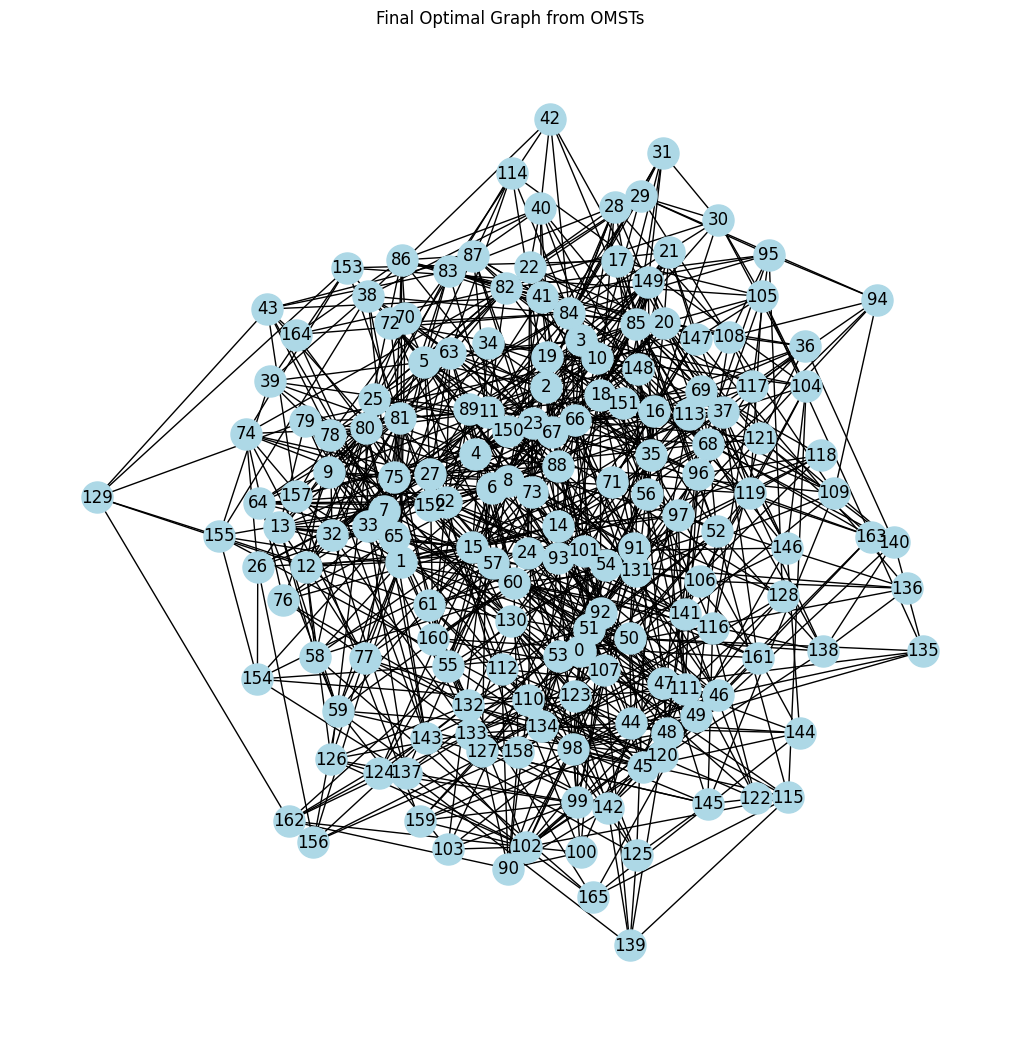

In [12]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500)
plt.title("Final Optimal Graph from OMSTs")
plt.show()  

-----------

### Compute OMST to all patients

In [14]:
Control_omst_graphs = []
for i in tqdm(range(len(control_correlation_matrix))):
    adj = control_correlation_matrix[i].copy()
    omst_builder = OMSTBuilder(adj)
    omst_builder.build(verbose=False)
    Control_omst_graphs.append(omst_builder.final_graph)

100%|██████████| 113/113 [00:33<00:00,  3.33it/s]


In [15]:
Prodomal_omst_graphs = []
for i in tqdm(range(len(prodomal_correlation_matrix))):
    adj = prodomal_correlation_matrix[i].copy()
    omst_builder = OMSTBuilder(adj)
    omst_builder.build(verbose=False)
    Prodomal_omst_graphs.append(omst_builder.final_graph)

100%|██████████| 188/188 [00:58<00:00,  3.23it/s]


In [16]:
Parkinson_omst_graphs = []
for i in tqdm(range(len(parkinson_correlation_matrix))):
    adj = parkinson_correlation_matrix[i].copy()
    omst_builder = OMSTBuilder(adj)
    omst_builder.build(verbose=False)
    Parkinson_omst_graphs.append(omst_builder.final_graph)

100%|██████████| 66/66 [00:18<00:00,  3.54it/s]


In [17]:
# Convert the final graph to a PyTorch Geometric Data object
def graph_to_pyg_data(graph: nx.Graph) -> Data:
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([graph[u][v]['weight'] for u, v in graph.edges], dtype=torch.float).view(-1, 1)
    x = torch.ones((graph.number_of_nodes(), 1))  # Node features (can be modified as needed)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [26]:
X = []
y = []
for graph in tqdm(Control_omst_graphs + Prodomal_omst_graphs + Parkinson_omst_graphs):
    pyg_data = graph_to_pyg_data(graph)
    if pyg_data.x.shape[0] == 166:
        # Only include graphs with 166 nodes
        y.append(0 if graph in Control_omst_graphs else (1 if graph in Prodomal_omst_graphs else 2))
        # Append the PyTorch Geometric Data object to the list
        X.append(pyg_data)    
#select in X only patients with 166 nodes

edge_indices = [data.edge_index for data in X]
edge_attrs = [data.edge_attr for data in X]
X = torch.stack([data.x for data in X], dim=0)
y = torch.tensor(y, dtype=torch.long)

100%|██████████| 367/367 [00:00<00:00, 1233.92it/s]


### Construction of Node Features

Vamos usar a abordagem 'Connection Profile'. The "connection profile" for a single node (an ROI) is its unique pattern of connectivity to all other nodes in the brain. In practical terms, it is simply its corresponding row (or column, since the matrix is symmetric) from the functional connectivity matrix.

In [28]:
X_node_features = X.clone()